In [1]:
import numpy as np
import tensorflow as tf
from pandas import read_csv
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2023-07-10 20:04:37.051225: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Import all datasets JAN 2008 . JUN 2023 per month

# Styringsrente 
kpra = read_csv("https://data.norges-bank.no/api/data/IR/M.KPRA..R?format=csv&startPeriod=2008-01-01&endPeriod=2023-05-01&locale=no&bom=include", sep=";")
p_rate = kpra[kpra["Løpetid"] == "Foliorenten"][["TIME_PERIOD", "OBS_VALUE"]]
p_rate.rename(columns={"TIME_PERIOD": "time", "OBS_VALUE":"value"}, inplace=True)
p_rate['value'] = p_rate['value'].str.replace(',', '.').astype(float)

# Exchange rate USD and EUR
ex_rate = read_csv("https://data.norges-bank.no/api/data/EXR/M.USD+EUR.NOK.SP?format=csv&startPeriod=2008-01-01&endPeriod=2023-05-26&locale=no&bom=include", sep=";")

# USD - NOK
er_dollar = ex_rate[ex_rate["BASE_CUR"] == "USD"][["TIME_PERIOD", "OBS_VALUE"]]
er_dollar.rename(columns={"TIME_PERIOD": "time", "OBS_VALUE":"value"}, inplace=True)
er_dollar['value'] = er_dollar['value'].str.replace(',', '.').astype(float)

# EUR - NOK
er_eur = ex_rate[ex_rate["BASE_CUR"] == "EUR"][["TIME_PERIOD", "OBS_VALUE"]]
er_eur.rename(columns={"TIME_PERIOD": "time", "OBS_VALUE":"value"}, inplace=True)
er_eur['value'] = er_eur['value'].str.replace(',', '.').astype(float)

# Unemployment rate (percent)
#unemployment = read_csv("https://www.ssb.no/statbank/sq/10084332", sep="\t", encoding='ISO-8859-1')
unemployment = read_csv("https://www.ssb.no/statbank/sq/10084480", sep="\t", encoding='ISO-8859-1')
unemployment = unemployment[["måned", "Arbeidsledige i prosent av arbeidsstyrken"]]
unemployment.rename(columns={"måned": "time", "Arbeidsledige i prosent av arbeidsstyrken":"value"}, inplace=True)
unemployment['value'] = unemployment['value'].astype(float)

# Consume price index
kpi = read_csv("https://www.ssb.no/statbank/sq/10084333", sep="\t", encoding='ISO-8859-1')
kpi = kpi[["måned", "Konsumprisindeks (2015=100)"]]
kpi.rename(columns={"måned": "time", "Konsumprisindeks (2015=100)":"value"}, inplace=True)
kpi["time"] = kpi["time"].str.replace("M", "-")
kpi['value'] = kpi['value'].astype(float)


# Net export
nx = read_csv("https://www.ssb.no/statbank/sq/10084504", sep="\t", encoding='ISO-8859-1')
nx = nx[["måned", "Verdi"]]
nx.rename(columns={"måned": "time", "Verdi":"value"}, inplace=True)
nx["time"] = nx["time"].str.replace("M", "-")
nx['value'] = nx['value'].astype(float)

#Production price index
ppi = read_csv('https://www.ssb.no/statbank/sq/10084588', sep="\t", encoding='ISO-8859-1')
ppi = ppi[["måned", "Produsentprisindeks (2015=100)"]]
ppi.rename(columns={"måned": "time", "Produsentprisindeks (2015=100)":"value"}, inplace=True)
ppi["time"] = ppi["time"].str.replace("M", "-")
ppi['value'] = ppi['value'].astype(float)


In [90]:
# TRAIN THE MODEL

X = np.stack((ppi['value'], er_dollar['value'], er_eur['value'], unemployment['value'], kpi['value']), axis=1)
y = p_rate['value']
X = X[24:]
y = p_rate['value'][24:]

split_index = int(len(X) * 0.8)

x_train, x_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

num_epochs = 500


# Opprette modellen
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(185*2, activation='relu'),
  tf.keras.layers.Dense(185*2, activation='relu'),
  tf.keras.layers.Dense(1)
])

# Kompilere modellen
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss='mse',
    metrics=['mae'])

# Trene modellen
history = model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_test, y_test))

# Evaluere modellen
model.evaluate(x_test, y_test)


Epoch 1/500
4/4 [==============================] - 1s 63ms/step - loss: 163.3489 - mae: 10.1298 - val_loss: 424.7734 - val_mae: 20.5892
Epoch 2/500
4/4 [==============================] - 0s 14ms/step - loss: 130.0168 - mae: 9.7269 - val_loss: 64.4374 - val_mae: 7.8085
Epoch 3/500
4/4 [==============================] - 0s 22ms/step - loss: 87.3640 - mae: 9.1541 - val_loss: 35.0693 - val_mae: 5.6945
Epoch 4/500
4/4 [==============================] - 0s 21ms/step - loss: 22.9692 - mae: 4.1513 - val_loss: 111.7620 - val_mae: 10.5590
Epoch 5/500
4/4 [==============================] - 0s 14ms/step - loss: 33.0832 - mae: 5.0380 - val_loss: 4.3776 - val_mae: 1.7317
Epoch 6/500
4/4 [==============================] - 0s 14ms/step - loss: 19.8055 - mae: 4.1414 - val_loss: 25.4514 - val_mae: 4.8281
Epoch 7/500
4/4 [==============================] - 0s 12ms/step - loss: 6.8803 - mae: 2.2057 - val_loss: 26.1221 - val_mae: 5.0771
Epoch 8/500
4/4 [==============================] - 0s 13ms/step - loss:

[1.023063063621521, 0.9431846737861633]

2/2 [==============================] - 0s 4ms/step


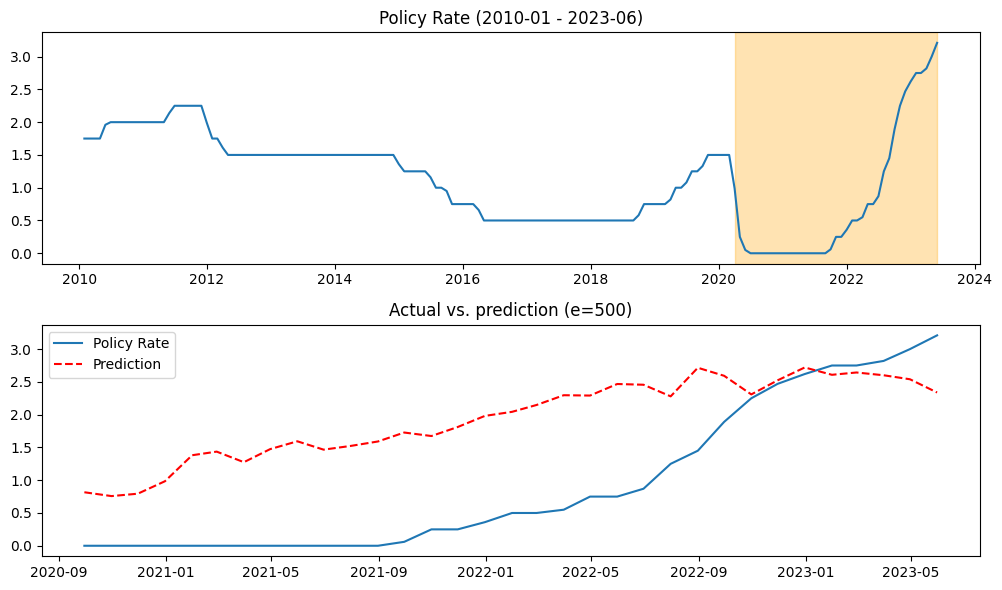

In [72]:
# PLOT ACTUAL VS. PREDICTION ON TEST DATA

predictions = model.predict(x_test)
months = pd.date_range('2010-01', '2023-06', freq='M')

fig, ax = plt.subplots(2,1,figsize=(10,6))


ax[0].plot(months, y)
ax[0].axvspan(months[122], months[-1], color='orange', alpha=0.3)
ax[0].set_title('Policy Rate (2010-01 - 2023-06)')
ax[1].plot(months[-33:], y_test, label='Policy Rate')
ax[1].plot(months[-33:], predictions, 'r--', label='Prediction')
ax[1].set_title('Actual vs. prediction (e=' + str(num_epochs) + ')')

plt.legend(loc="upper left")

plt.tight_layout()

plt.show()

6/6 [==============================] - 0s 4ms/step


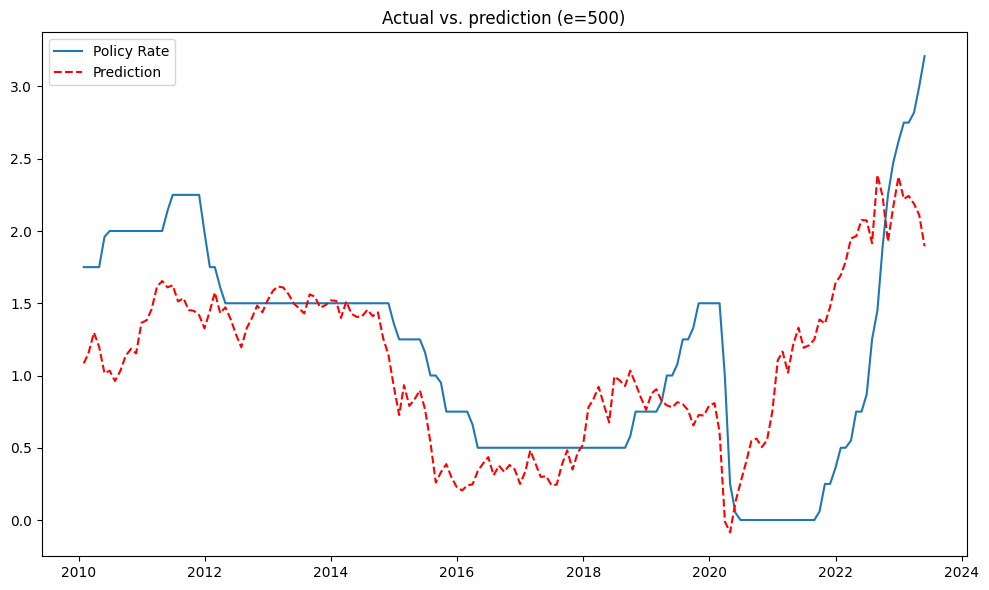

In [91]:
# PLOT MODELS PREDICTION ON WHOLE DATASET

fig, ax = plt.subplots(figsize=(10,6))

predictions = predictions = model.predict(X)

ax.plot(months, y, label='Policy Rate')
ax.plot(months, predictions, 'r--', label='Prediction')
ax.set_title('Actual vs. prediction (e=' + str(num_epochs) + ')')

plt.legend(loc="upper left")

plt.tight_layout()

plt.show()

In [93]:
# PRINT TABLE OF VALIDATION METRICS

from prettytable import PrettyTable
from sklearn.metrics import mean_absolute_error, mean_squared_error

predictions = model.predict(x_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)



table = PrettyTable(['Type', 'Value'])
table.add_row(["Mean Absolute Error: ", mae])
table.add_row(["Mean Squared Error: ", mse])
table.add_row(["Root Mean Squared Error: ", rmse])

print(table)

2/2 [==============================] - 0s 3ms/step
+---------------------------+--------------------+
|            Type           |       Value        |
+---------------------------+--------------------+
|   Mean Absolute Error:    | 0.9431847027576331 |
|    Mean Squared Error:    | 1.0230631430408947 |
| Root Mean Squared Error:  | 1.0114658387908584 |
+---------------------------+--------------------+
